In [289]:
import pandas as pd
import numpy as np
import json
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string
from collections import Counter
import re
from bs4 import BeautifulSoup
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

In [290]:
import twitter

def oauth_login():
    # write your code here
    # return a Twitter object
    auth = twitter.oauth.OAuth(consumer_key = '',
                              consumer_secret = '',
                              token = '',
                              token_secret = '')
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

twitter_api=oauth_login()

In [291]:
print(twitter_api)

In [292]:

def get_twitter(account):
    dt = twitter_api.statuses.user_timeline(screen_name = account,count=200, tweet_mode ='extended')
    
    #save to JSON all data
    with open(account + '.json','w') as file:
        json.dump(dt,file)
    
    #Get just tweets and favorite count
    tweets = []
    favorite_c = []
    for i in range(len(dt)):
        if 'RT @' not in dt[i]['full_text'] and 'http' not in dt[i]['full_text']:
            tweets.append(dt[i]['full_text'])
            favorite_c.append(dt[i]['favorite_count'])
    
    #create dictionary of tweets and favorite counts
    tweet_dict = {'tweets':tweets,
              'favorite_count':favorite_c}
    
    #save to json just tweets and favorites
    with open(account+'just_tweets.json','w') as file:
        json.dump(tweet_dict,file)
    
    #open json file to keep using
    with open(account + 'just_tweets.json') as json_file:
        data = json.load(json_file)
    return data


In [293]:

def clean_text1(tuk_text):
    tuk_ready_stem = []
    from nltk.stem.snowball import SnowballStemmer

    stem = SnowballStemmer("english")

    stopw = stopwords.words('english') + list(string.punctuation)  +["’","”","—","“"]
    for i in range(0,len(tuk_text)):
        x = tuk_text[i]
        text = re.sub(r'((.)\2{2,})', ' ', x) #remove three or more consecutive characters like 'trashhhh'
        text = re.sub('[^a-zA-Z0-9]', ' ', text)


        #Words
        tokens = [stop for stop in word_tokenize(text.lower()) if stop not in stopw] #removes stopwords, punctuation and custom filter
        #tokens = [w for w in tokens if w.isalpha()]  #remove every that is not fully alphabetic
        #tokens = [w for w in tokens if re.findall(r"(\w{3})",w) ] #removes anything less than 3 characters
        #tokens = [stem.stem(w) for w in tokens]
        review = ' '.join(tokens)
        tuk_ready_stem.append(review)
    return(tuk_ready_stem)


In [294]:
def lda_gettopics(clean_text):
    lda = LatentDirichletAllocation(n_components=20,random_state=22)
    vect = CountVectorizer(ngram_range=(1,3),min_df=2)
    fitted = vect.fit(clean_text)
    trans = fitted.transform(clean_text)
    lda.fit(trans)
    topic_weights = lda.transform(trans)
    
    topics = []
    for i in topic_weights:
        topics.append(np.argmax(i))
    return topics,lda,vect,topic_weights
def print_LDA_results(lda_model, feature_names, n_top_words=15):
    all_topics = []
    for topic_idx, topic in enumerate(lda_model.components_):
        #message = "Topic %d:" % topic_idx
        message = " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        all_topics.append(message)
        #print(message)
        #print()
    return all_topics



In [295]:
def bin_the_tweets(clean_text,weights):
    my_stuff['clean_text'] = clean_text
    my_stuff['topics'] = weights
    x = zip(my_stuff['favorite_count'],my_stuff['clean_text'],my_stuff['topics'])
    x1 = list(x)

    length= int(len(x1)/3)

    low_bin = sorted(x1)[0:length]
    med_bin = sorted(x1)[length:length*2]
    high_bin = sorted(x1)[length*2:length*3]
    
    return low_bin,med_bin,high_bin



In [296]:
from collections import Counter
def get_best_topic(bins):
    tops = []
    for i in bins:
        tops.append(i[2])
    return(Counter(tops).most_common(1)[0][0])


realDonaldTrump tweet results
Most common topic of low favorite tweets:   total want total endorsement endorsement complete fred republican complete total endorsement complete total foxnews dems mueller congress crime pennsylvania
################################################
Most common topic of medium favorite tweets:   china way people life wants mueller deal mr like know report position bad last million
################################################
Most common topic of high favorite tweets:   china buy tariffs product us many tariffed country make united nancy states much time united states
################################################
Word cloud for topic of high favorite tweets


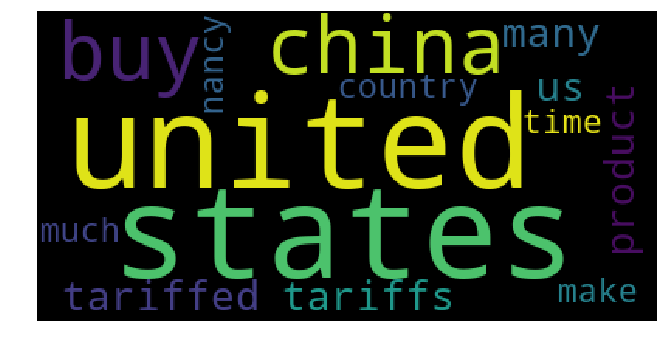



AOC tweet results
Most common topic of low favorite tweets:   women leave living society time nation us good policy think basic religious public power many
################################################
Most common topic of medium favorite tweets:   weeks law 12 use take would year 12 weeks force forces days people pregnancy home etc
################################################
Most common topic of high favorite tweets:   people committee issue leadership everyday everyday people oversight committee oversight case issues much house power saw command
################################################
Word cloud for topic of high favorite tweets


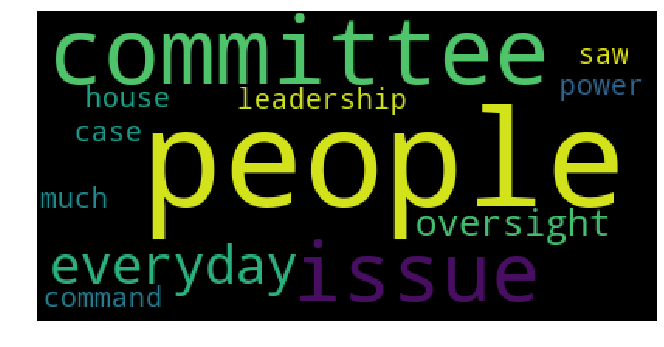



elonmusk tweet results
Most common topic of low favorite tweets:   tesla amp hours nozzle tesla yes alex oha alex oha vacuum yes years close though would much
################################################
Most common topic of medium favorite tweets:   yes nichegamer spacex worldandscience spacex yes fischer fischer worldandscience course insideevs punishedfranc83 spacexstarlink spacex punishedfranc83 spacexstarlink punishedfranc83 spacexstarlink spacex spacexstarlink time
################################################
Most common topic of high favorite tweets:   erdayastronaut spacex erdayastronaut spacex some1gee erdayastronaut some1gee erdayastronaut spacex sword some1gee erdayastronaut some1gee orion sword sword orion sword some1gee sword some1gee orion bluemoondance74 bluemoondance74 orion sword bluemoondance74 orion
################################################
Word cloud for topic of high favorite tweets


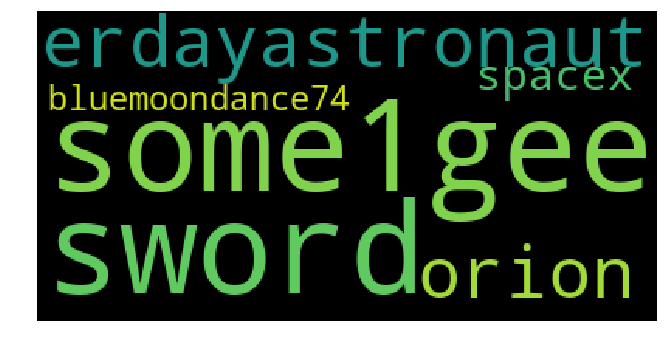

In [310]:
acts = ['realDonaldTrump', 'AOC', 'elonmusk']
for act in acts:
    tw = get_twitter(act)
    ct = clean_text1(tw['tweets'])
    tps,ld, vec,weights = lda_gettopics(ct)
    nms = vec.get_feature_names()
    res = print_LDA_results(ld,nms)
    l,m,h = bin_the_tweets(ct,tps)
    low_top = get_best_topic(l)
    med_top = get_best_topic(m)
    high_top = get_best_topic(h)
    DF = pd.DataFrame()
    DFW = pd.DataFrame(weights)
    DF['tweet']=ct
    DF['favorite_count'] = tw['favorite_count']
    DF_all = pd.concat([DF, DFW], axis=1)
    DF_all.to_csv(act+'.csv', index = False)
    print(act, 'tweet results')
    print('Most common topic of low favorite tweets:  ',res[low_top])
    print('################################################')
    print('Most common topic of medium favorite tweets:  ',res[med_top])
    print('################################################')
    print('Most common topic of high favorite tweets:  ',res[high_top])
    print('################################################')
    print('Word cloud for topic of high favorite tweets')
    %matplotlib inline
    wc = WordCloud().generate(res[high_top])
    plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
    plt.axis('off')
    plt.imshow(wc)
    plt.show()
    print()
    print()